In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow--gpu
!pip install --upgrade Keras
!pip install --upgrade Keras-Applications
!pip install --upgrade Keras-Preprocessing

In [ ]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
import random
import os
import numpy as np
import tensorflow as tf
from keras.layers import Conv2D, concatenate, add

In [ ]:
!pip install kaggle

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

In [ ]:
!unzip 'dogs-vs-cats.zip'

In [ ]:
!unzip 'train.zip'

In [ ]:
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random

# create directories
dataset_home = 'cats_and_dogs_filtered/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'train/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random() < val_ratio:
        dst_dir = 'test/'
    if file.startswith('cat'):
        dst = dataset_home + dst_dir + 'cats/'  + file
        copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_home + dst_dir + 'dogs/'  + file
        copyfile(src, dst)

In [ ]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_width = 224
image_height = 224

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_directory(
        '/content/cats_and_dogs_filtered/train',
        target_size=(image_width, image_height),
        batch_size=100,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        '/content/cats_and_dogs_filtered/test',
        target_size=(image_width, image_height),
        batch_size=100,
        class_mode='categorical')

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


In [ ]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    
    nb_filter1, nb_filter2, nb_filter3 = filters
    #if K.image_dim_ordering() == 'tf':
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    '''
    x = Convolution2D(nb_filter1, 1, 1, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size,
                      border_mode='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
    '''
    # test
    x = Conv2D(nb_filter1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter2, (kernel_size, kernel_size), 
                      padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
    # test

    #x = merge([x, input_tensor], mode='sum')
    x = add([x, input_tensor])

    x = Activation('relu')(x)
    return x

In [ ]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):

    nb_filter1, nb_filter2, nb_filter3 = filters
    #if K.image_dim_ordering() == 'tf':
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    '''
    x = Convolution2D(nb_filter1, 1, 1, subsample=strides,
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size, border_mode='same',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Convolution2D(nb_filter3, 1, 1, subsample=strides,
                             name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)
    '''

    # test
    x = Conv2D(nb_filter1, (1, 1), strides=strides,
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(nb_filter3, (1, 1), strides=strides,
                             name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)
    # test

    #x = merge([x, shortcut], mode='sum')
    x = add([x, shortcut])

    x = Activation('relu')(x)
    return x

In [ ]:
img_input = Input(shape=(image_width, image_height, 3))

x = ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
#x = Convolution2D(64, 7, 7, subsample=(2, 2), name='conv1')(x)
x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)

x = BatchNormalization(axis=3, name='bn_conv1')(x)
x = Activation('relu')(x)

x = ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)

x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

base_model = Model(img_input, x, name='resnet50')

In [ ]:
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        TF_WEIGHTS_PATH_NO_TOP,
                        cache_subdir='models',
                        md5_hash='a268eb855778b3df3c7506639542a6af')
base_model.load_weights(weights_path)

In [ ]:
'''
x = GlobalAveragePooling2D(name='avg_pool')(base_model.output)
#x = Flatten()(x)
#x = Dropout(0.5)(x)
x = Dense(2, activation='softmax', name='output')(x)
model = Model(inputs=base_model.input, outputs=x)
'''
x = Sequential()
x = GlobalAveragePooling2D(name='avg_pool')(base_model.output)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='sigmoid', name='output')(x)
model = Model(inputs=base_model.inputs, outputs=x)

In [ ]:
top_num = 4
for layer in model.layers[:-top_num]:
    layer.trainable = False

for layer in model.layers[-top_num:]:
    layer.trainable = True

In [ ]:
sgd = SGD(lr = 1e-3, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

In [ ]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '/content/resnet_best.h5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=10,
        validation_data=validation_generator,
        validation_steps=len(validation_generator), 
        callbacks=[cb_checkpointer, cb_early_stopper])

Epoch 1/10
187/187 [==============================] - 173s 926ms/step - loss: 0.1519 - accuracy: 0.9405 - val_loss: 0.0500 - val_accuracy: 0.9841
Epoch 2/10
187/187 [==============================] - 172s 917ms/step - loss: 0.0634 - accuracy: 0.9781 - val_loss: 0.0434 - val_accuracy: 0.9849
Epoch 3/10
187/187 [==============================] - 171s 917ms/step - loss: 0.0524 - accuracy: 0.9812 - val_loss: 0.0385 - val_accuracy: 0.9871
Epoch 4/10
187/187 [==============================] - 172s 918ms/step - loss: 0.0543 - accuracy: 0.9804 - val_loss: 0.0370 - val_accuracy: 0.9870
Epoch 5/10
187/187 [==============================] - 172s 917ms/step - loss: 0.0464 - accuracy: 0.9831 - val_loss: 0.0355 - val_accuracy: 0.9879
Epoch 6/10
187/187 [==============================] - 171s 917ms/step - loss: 0.0429 - accuracy: 0.9856 - val_loss: 0.0351 - val_accuracy: 0.9879
Epoch 7/10
187/187 [==============================] - 171s 916ms/step - loss: 0.0403 - accuracy: 0.9856 - val_loss: 0.0344 -

In [ ]:
import glob
from random import shuffle
from tensorflow.python.keras.models import load_model

list_dir = glob.glob("/content/test1/*.jpg")

In [ ]:
model3 = load_model('/content/resnet_best.h5')

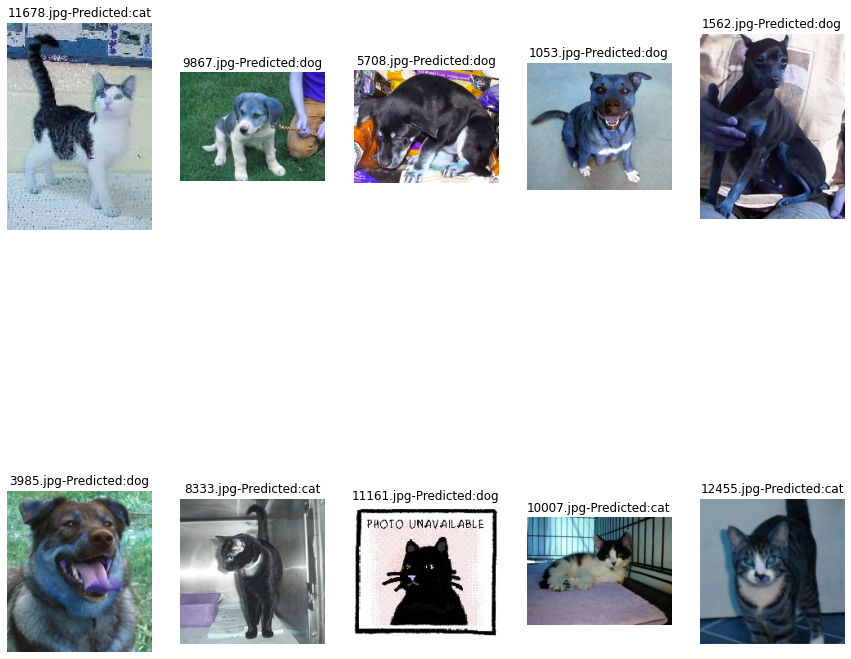

In [ ]:
import cv2
import matplotlib.pyplot as plt
IMAGE_RESIZE = 224

f, ax = plt.subplots(2, 5, figsize = (15, 15))
shuffle(list_dir)
for i in range(0,10):
    img = cv2.imread(list_dir[i])
    img2 = cv2.resize(img,(IMAGE_RESIZE,IMAGE_RESIZE))
    img2 = np.reshape(img2,[1,IMAGE_RESIZE,IMAGE_RESIZE,3])
        
    result = model3.predict(img2)

    classify = 'cat' if result[0, 0] > result[0, 1] else 'dog'
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("{}-Predicted:{}".format(list_dir[i].replace('/content/test1/',''), classify))    

plt.show()